In [1]:
import geopandas as gpd
from osgeo import ogr
import pandas as pd
import tifffile as tiff #needed for the tif data for perry county
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
from math import sin, cos, sqrt, atan2, radians
import sys
from shapely.geometry import Polygon, box, Point, LineString, MultiLineString
import pickle
import gurobipy as gp
from gurobipy import GRB
import tifffile as tiff #needed for the tif data for perry county
import xlwt
from xlwt import Workbook
from shapely.ops import snap, split, nearest_points
#from shapely.geometry import MultiPoint, LineString
#from dbfread import DBF
import osmnx as ox
import networkx as nx
import math
import gurobipy as gp
from gurobipy import GRB
import os
import csv
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt

In [2]:
# calculate distance
def haversinedist(lat1, lon1, lat2, lon2):
    R = 6373.0
    
    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)
    
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    
    distance = R * c
    return distance #unit in km

In [3]:
# read data
def readClusterFile(fileID):
    file = np.genfromtxt(fileID, delimiter=",", skip_header = 1)
    file = file[:,1:]
    return file
clusterfile = 'Centralized_elevcluster' + str(1) + '.csv'

In [4]:
# read data
def readClusterFile(fileID):
    file = np.genfromtxt(fileID, delimiter=",", skip_header = 1)
    file = file[:,1:]
    return file
clusterfile = 'Centralized_elevcluster' + str(1) + '.csv'
building_coords = readClusterFile(clusterfile)

In [5]:
# pipe parameters
pipesize = [0.05, 0.06, 0.08, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.6] #m
pipesize_str, pipecost = gp.multidict({'0.05': 8.7, '0.06': 9.5, '0.08': 11, \
                                                   '0.1': 12.6, '0.15': 43.5,'0.2': 141, '0.25': 151, '0.3': 161, '0.35':230, '0.4': 246, '0.45':262, 
                                                   '0.5':292, '0.6':315}) #$/m
excavation = 25
bedding_cost_sq_ft = 6
capital_cost_pump_station = 166000
ps_flow_cost = 0.19
ps_OM_cost = 175950

In [6]:
# creat MST

graph = []
mstree = []
def createMSTnx(dataframe,n):
    #only takes longitude and latitude from the cluster data, note we also have elevation and stuff there too
    #coordinates = twoDcluster
    cluster = AgglomerativeClustering(n_clusters=n, affinity='euclidean', linkage='ward')
    cluster.fit_predict(building_coords[:,1:2])
    # add cluster to dataframe
    dataframe['cluster.labels_'] = cluster.labels_.tolist()
    for k in range(n):
        cluster_label = dataframe[dataframe['cluster.labels_'] == k]
        cluster_label = cluster_label[['longitude','latitude']]
        latlon = cluster_label.to_numpy()
        nrows, ncols = latlon.shape
        #creates graph
        graph.append(nx.Graph())
        weights = []
        #distance in km as weight between each point in the graph
        for i in range(nrows):
            graph[k].add_node(i,pos=(latlon[i,0],latlon[i,1]))
            for j in range(i+1,nrows):
                dist = haversinedist(latlon[i,1], latlon[i,0], latlon[j,1], latlon[j,0])
                weights.append(dist)
                graph[k].add_edge(i,j, weight = dist)
        #creates MST
        mstree.append(nx.minimum_spanning_tree(graph[k]))
    return mstree, graph

In [7]:
#convert data to dataframe
df = pd.DataFrame(building_coords,
                  columns = ['longitude','latitude','elevation'])
createMSTnx(df,100)

([<networkx.classes.graph.Graph at 0x7ff6ec85ef10>,
  <networkx.classes.graph.Graph at 0x7ff6ecc07c70>])

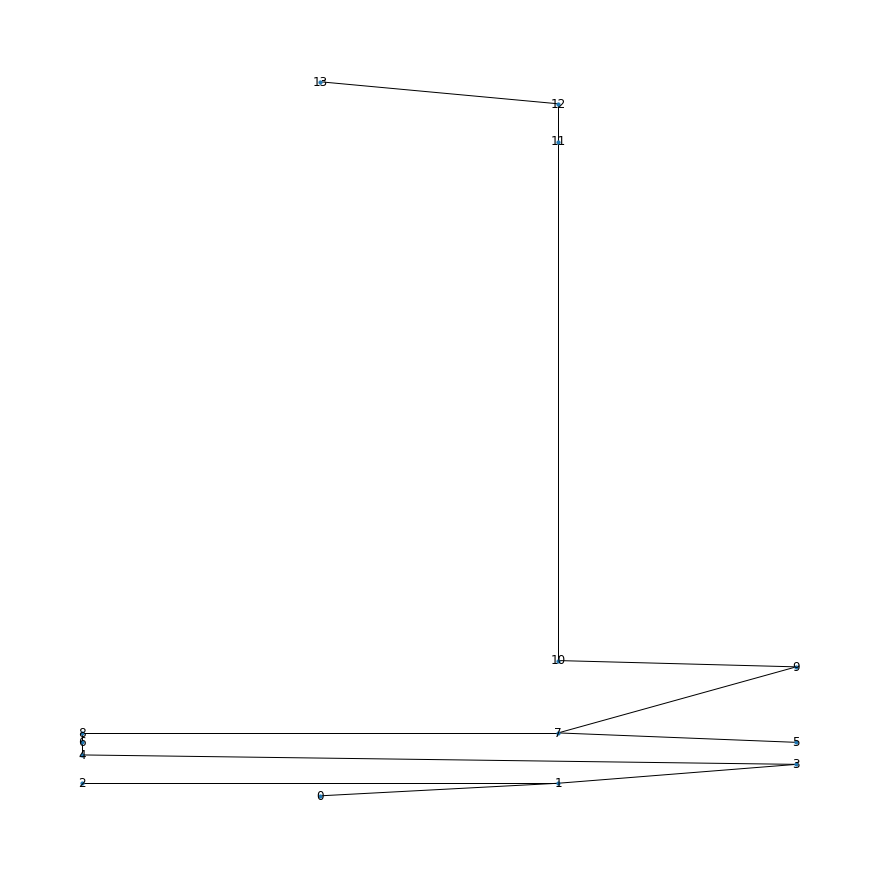

In [8]:
pos = {city:(long, lat) for (city, (lat,long)) in nx.get_node_attributes(mstree[7], 'pos').items()}
plt.figure(3,figsize=(12,12)) 
nx.draw(mstree[7], pos, with_labels=True, node_size=10)
plt.show()

In [9]:
def minlp(cluster_labels, pipesize, pipecost, water_demand, HLmax, excavation, bedding_cost_sq_ft, capital_cost_pump_station, ps_OM_cost):
    
    # select highest and lowest nodes in cluster
    tank = df.loc[df.groupby(['cluster.labels_'])['elevation'].idxmax()].reset_index(drop=True)
    trem = df.loc[df.groupby(['cluster.labels_'])['elevation'].idxmin()].reset_index(drop=True)
                      
     # find label of tank node in cluster
    tank_lon = str(tank[tank['cluster.labels_'] == cluster_labels][['longitude']].iat[0,0])
    tank_lat = str(tank[tank['cluster.labels_'] == cluster_labels][['latitude']].iat[0,0])
    for i in mstree[cluster_labels].nodes():
        if str(mstree[cluster_labels].nodes[i]['pos'][0]) == tank_lon and str(mstree[cluster_labels].nodes[i]['pos'][1]) == tank_lat:
            tank_node = i                  
    #create flow direction dict
    links = list(mstree[cluster_labels].edges)
    flow_dir = {}
    for i,j in links:
        if len(nx.shortest_path(mstree[cluster_labels],source=tank_node, target=i)) < len(nx.shortest_path(mstree[cluster_labels],source=tank_node, target=j)):
        # if node i is nearer to tank
           flow_dir[i,j]=(i,j)
        if len(nx.shortest_path(mstree[cluster_labels],source=tank_node, target=i)) > len(nx.shortest_path(mstree[cluster_labels],source=tank_node, target=j)):
         # if node j is nearer to tank
           flow_dir[i,j]=(j,i) 
    innode = {}
    outnode = {}
    for i,j in links:
        if len(nx.shortest_path(mstree[cluster_labels],source=tank_node, target=i)) > len(nx.shortest_path(mstree[cluster_labels],source=tank_node, target=j)):
           # if node j is nearer to tank
            innode.setdefault(i, [])
            innode[i].append(j)
            outnode.setdefault(j, [])
            outnode[j].append(i)
        else:
           # if node i is nearer to tank
            innode.setdefault(j, [])
            innode[j].append(i)
            outnode.setdefault(i, [])
            outnode[i].append(j)
    for i in mstree[cluster_labels].nodes():
        innode.setdefault(i,[])
        outnode.setdefault(i, [])
   # directed graph
    mstree_dir = nx.DiGraph()
    mstree_dir.add_nodes_from(mstree[cluster_labels])
    mstree_dir.add_edges_from(flow_dir.values())
    weights = {}
    for i in list(mstree_dir.edges()):
        weights[i] = None
    for i,j in flow_dir:
        if flow_dir[i,j]==(i,j):
            weights[i,j]=mstree[cluster_labels].edges[i,j]['weight']
        if flow_dir[i,j]==(j,i):
            weights[j,i]=mstree[cluster_labels].edges[i,j]['weight']
    nx.set_edge_attributes(mstree_dir, values = 1, name = 'weight')
    nx.set_edge_attributes(mstree_dir, values = weights, name = 'weight')
    # determine iterate order
    walk = {}
    for i,j in mstree_dir.edges():
        walk[i,j] = len(nx.shortest_path(mstree_dir ,source=tank_node, target=j))
    sorted_walk = dict(sorted(walk.items(), key=lambda item: item[1], reverse = True))
    # pipe flow
    pipe_flow = {}
    for i,j in sorted_walk:
        if len(outnode[j]) == 0:
            pipe_flow[i,j] = 1.095E-5
        else:
            pipe_flow[i,j] = sum(pipe_flow[m,n] for m,n in sorted_walk if m == j) + 1.095E-5
   # Edge list
    edge_list = {}
    for i,j in links:
        if (i,j) == flow_dir[i,j]:
            edge_list[i,j] =[pipe_flow[i,j],mstree[cluster_labels][i][j]["weight"]]
        else:
            edge_list[j,i] =[pipe_flow[j,i],mstree[cluster_labels][i][j]["weight"]]
   #node elevation excavation in meters
   #upper bound is arbritrary maximum depth assuming 1 foot or 0.3048 meters of cover beneath the surface is needed for the pipes
   #a lower bound variable is created but not used. In future models might need to implement that depending on the site (digging too deep for excavation is not feasible for many projects)
    cluster = df[df['cluster.labels_'] == cluster_labels]
    cluster_elv = cluster[['elevation']]
    elevation_ub = dict()
    elevation_lb = dict()
    for i in range(mstree[cluster_labels].number_of_nodes()):
        elevation_ub[i] = cluster_elv.iloc[[i]] - 0.3048
        elevation_lb[i] = cluster_elv.iloc[[i]] - 30                 
    m = gp.Model('pipe and pump distribution')
    m.Params.timeLimit = 12000
   # binary variable indicating if at link ij pipe of diameter k is implemented
    d = m.addVars(mstree_dir.edges(), pipesize, vtype = GRB.BINARY, name = "diameter")
   #continuous variable representing the hydro loss in link ij.
    HL = m.addVars(mstree_dir.edges(),lb = 0, vtype = GRB.CONTINUOUS, name = "hydro loss")
    # hydro gradient
    #J = m.addVars(mstree[cluster_labels].edges(),lb = 0, vtype = GRB.CONTINUOUS, name = "hydro gradient")
   # binary variable indicating if at link ij the pump of type m is implemented.
    p = m.addVars(mstree_dir.edges(), vtype = GRB.BINARY, name = "PUMP")
   #continuous variable representing the pressure injected by the pump at link ij.
    pr = m.addVars(mstree_dir.edges(),lb = 0, vtype = GRB.CONTINUOUS, name = "PRESSURE BY PUMP")
   #pipe elevations at node i 
    e = m.addVars(mstree_dir.nodes(), lb = 0, vtype = GRB.CONTINUOUS, name = 'In Node Elevation')
   #continuous variable representing the head pressure at node i
    H = m.addVars(mstree_dir.nodes(),lb = 0, vtype = GRB.CONTINUOUS, name = "HEAD PRESSURE")
    for i,j in mstree_dir.edges():
#Hazen Williams equation, A = 10700, C=140, P472
        #m.addConstr(J[i,j] == 
                #10700*(edge_list[i,j][0]/140)**1.852*gp.quicksum(d[i,j,k]/(k**4.8704) for k in pipesize)
               #, "Hydro loss")
        m.addConstr(HL[i,j] == 10700*(edge_list[i,j][0]/140)**1.852*gp.quicksum(d[i,j,k]/(k**4.8704) for k in pipesize)*1000*mstree_dir[i][j]["weight"])
        m.addConstr(HL[i,j] <= HLmax)
#only one pipe per edge
        m.addConstr((d.sum(i, j, '*') == 1.0), "single size chosen")
#injected pressure pr[i,j] must be less than a huge number.
        m.addConstr(pr[i,j]<=p[i,j]*10**6)
    # energy requirement
        m.addConstr(H[j] == H[i] - HL[i,j] + e[i] - e[j] + pr[i,j], "Energy balance")
    
        #if len(nx.shortest_path(mstree[cluster_labels],source=tank_node, target=i)) < len(nx.shortest_path(mstree[cluster_labels],source=tank_node, target=j)):
        # if node i is nearer to tank        
            #m.addConstr(H[j] == H[i] -HL[i,j] + e[i] - e[j] + pr[i,j], "Energy balance")
        #if len(nx.shortest_path(mstree[cluster_labels],source=tank_node, target=i)) > len(nx.shortest_path(mstree[cluster_labels],source=tank_node, target=j)):
        # if node j is nearer to tank        
            #m.addConstr(H[i] == H[j] -HL[i,j] + e[j] - e[i] + pr[i,j], "Energy balance")
# Velocity must be between 0.6 and 3 m/s to 30
        m.addConstr((
           edge_list[i,j][0] <= ((3.14/4)*gp.quicksum(d[i,j,k]*k**2 for k in pipesize)) * 3), "Velocity Max Constr"+ str([i,j]))
        #m.addConstr((
           #edge_list[i,j][0] >= ((3.14/4)*gp.quicksum(d[i,j,k]*k**2 for k in pipesize)) * 0.6), "Velocity Min Constr" + str([i,j]))  
    for i in mstree_dir.nodes():
#pipe elevation must be betwenn lb and ub
        m.addConstr(e[i] >= float(str(elevation_lb[i])[20:]), "PIPE ELV LB")
        m.addConstr(e[i] <= float(str(elevation_ub[i])[20:]), "PIPE ELV UB")
    
        m.addConstr(H[i] >= 31.646232670592248, "Min head pressure") #45 psi, covert it to m
        m.addConstr(H[i] <= 56.26, "Ma head pressure") #80 psi, covert it to m
        
    m.addConstr(H[tank_node] == 31.646232670592248)
                      
                      
    # pipe cost 
    obj1 = gp.quicksum(1000 * mstree_dir[i][j]["weight"] * gp.quicksum(pipecost[str(k)] * d[i, j, k] 
                                                           for k in pipesize) for i,j in mstree_dir.edges())
    # Capital cost of pump stations
    obj2 = gp.quicksum(p.sum(i, j) * capital_cost_pump_station for i,j in mstree_dir.edges())

    #Operation and maintenance costs
    obj3 = gp.quicksum(p.sum(i, j)*ps_OM_cost for i, j in mstree_dir.edges())

    obj = obj1+obj2+obj3                  
    m.setObjective(obj, GRB.MINIMIZE)
    m.optimize()
    
    
    #save the result
    modelname = "pipe&pump distri" + str(cluster_labels) + ".csv" 
        #m.write(modelname)
    modelfile = open(modelname, "w")
    #modelfile.write("pipecost" + str(pipecost))
    modelfile.write('number of nodes: %g \n' % len(mstree[cluster_labels].nodes()))
    modelfile.write('capital_cost_pump_station: %g \n' % capital_cost_pump_station)
    modelfile.write('ps_OM_cost: %g \n' % ps_OM_cost)
    modelfile.write('water_demand: %g \n' % water_demand)
    modelfile.write('Solution Value: %g \n' % m.objVal)
    modelfile.write('Solution Value 1: %g \n' % obj1.getValue())
    modelfile.write('Solution Value 2: %g \n'% obj2.getValue())
    modelfile.write('Solution Value 3: %g \n'% obj3.getValue())                  
    for v in m.getVars():
        modelfile.write('%s %g \n' % (str(v.varName), v.x))
    modelfile.close()
    
    return obj.getValue(), obj1.getValue(), obj2.getValue(), obj3.getValue(), edge_list, tank_node, flow_dir, innode, outnode
                      

In [10]:
minlp(7, pipesize, pipecost, 1.095E-5, 1e+5, excavation, bedding_cost_sq_ft, capital_cost_pump_station, ps_OM_cost)

Set parameter Username
Academic license - for non-commercial use only - expires 2022-09-18
Set parameter TimeLimit to value 12000
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 135 rows, 236 columns and 694 nonzeros
Model fingerprint: 0xc15c7420
Variable types: 54 continuous, 182 integer (182 binary)
Coefficient statistics:
  Matrix range     [2e-07, 1e+06]
  Objective range  [2e+02, 5e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 1e+05]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Found heuristic solution: objective 1982770.7313
Presolve removed 99 rows and 43 columns
Presolve time: 0.00s
Presolved: 36 rows, 193 columns, 372 nonzeros
Found heuristic solution: objective 1975669.2385
Variable types: 25 continuous, 168 integer (168 binary)

Root relaxation: objective 1.794919e+04, 31 iteratio

(17949.18930633201,
 17949.18930633201,
 0.0,
 0.0,
 {(1, 0): [1.095e-05, 0.036260956532509755],
  (1, 2): [1.095e-05, 0.020598117254466697],
  (3, 1): [3.285e-05, 0.053158577216783666],
  (4, 3): [4.38e-05, 0.04042991226060577],
  (6, 4): [5.475e-05, 0.03476765859900658],
  (7, 5): [1.095e-05, 0.028035897336307323],
  (8, 6): [6.57e-05, 0.026075743954634866],
  (7, 8): [7.664999999999999e-05, 0.020598117254466697],
  (9, 7): [9.854999999999998e-05, 0.1828200651227754],
  (9, 10): [4.38e-05, 0.020205607579428214],
  (10, 11): [3.285e-05, 1.4341629699702085],
  (11, 12): [2.19e-05, 0.10430276153936785],
  (12, 13): [1.095e-05, 0.06170882300380795]},
 9,
 {(0, 1): (1, 0),
  (1, 2): (1, 2),
  (1, 3): (3, 1),
  (3, 4): (4, 3),
  (4, 6): (6, 4),
  (5, 7): (7, 5),
  (6, 8): (8, 6),
  (7, 8): (7, 8),
  (7, 9): (9, 7),
  (9, 10): (9, 10),
  (10, 11): (10, 11),
  (11, 12): (11, 12),
  (12, 13): (12, 13)},
 {0: [1],
  2: [1],
  1: [3],
  3: [4],
  4: [6],
  5: [7],
  6: [8],
  8: [7],
  7: [9],
